In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import seaborn as sns
import matplotlib.gridspec as gridspec

from cigma import plot

In [2]:
# simulation parameters
real = np.load('../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/he.npy', allow_pickle=True).item()
P = pd.read_table('../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/P.final.gz', index_col=0)
nu = pd.read_table('../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/nu.final.gz', index_col=0)[real['gene']]
print(f'Number of genes: {len(real["gene"])}')
assert np.all(real['gene'] == nu.columns.to_numpy())
# print(P.head())
# print(nu.head())

N, C = P.shape

# variance components
var_v = np.trace(real['free']['V'] @ (P.values.T @ P.values), 
                    axis1=1, axis2=2) / N
var_w = np.trace(real['free']['W'] @ (P.values.T @ P.values), 
                    axis1=1, axis2=2) / N
S = np.cov(P.values.T)
var_beta = (real['free']['ct_beta'] @ S) * real['free']['ct_beta']
var_beta = var_beta.sum(axis=1)
op = real['free']['hom_g2'] + real['free']['hom_e2'] + var_v + var_w + var_beta + nu.mean().to_numpy()

xs = var_v / op
index = np.argsort(xs)
k = 5000
print(xs[index][-3:])

print(f'Proportion of OP explained by mean expression: {np.mean((var_beta / op)[index][-k:])}')
print(f'Proportion of OP explained by shared gen: {np.mean((real["free"]["hom_g2"] / op)[index][-k:])}')
print(f'Proportion of OP explained by shared env: {np.mean((real["free"]["hom_e2"] / op)[index][-k:])}')
print(f'Proportion of OP explained by specific gen: {np.mean((var_v / op)[index][-k:])}')
print(f'Proportion of OP explained by specific env: {np.mean((var_w / op)[index][-k:])}')
print(f'Proportion of OP explained by cell noise: {np.mean((nu.mean().to_numpy() / op)[index][-k:])}')
print(f'Coefficient of variation of interindividual cell noise variance: {np.mean((nu.std().to_numpy() / nu.mean().to_numpy())[index][-k:])}')

Number of genes: 10288
[0.47461413 0.47988572 0.60831493]
Proportion of OP explained by mean expression: 0.12953961483595924
Proportion of OP explained by shared gen: 0.044432677556596564
Proportion of OP explained by shared env: 0.16009950730786254
Proportion of OP explained by specific gen: 0.012390926408027102
Proportion of OP explained by specific env: 0.05871964670196485
Proportion of OP explained by cell noise: 0.5948176271895896
Coefficient of variation of interindividual cell noise variance: 0.46541499148781734


In [3]:
# # NOTE: keep
# check snps 
# # several genes in scRNA-seq don't have SNPs, the others all have more than 5 SNPs
# snps = []
# kinship_genes = []
# for chr in range(1, 23):
#     kinship = np.load(f'../../analysis/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9_geno_pca_n~6_op_pca_n~1_batch~shared_fixed~shared/kinship.chr{chr}.npy', allow_pickle=True).item()
#     kinship_genes += kinship['gene']
#     snps += kinship['nsnp']
# kinship_df = pd.DataFrame({'gene': kinship_genes, 'nsnp': snps})
# print(kinship_df.shape)

In [4]:
# NOTE: keep
# check cell #
obs = pd.read_table('../../analysis/yazar/exclude_repeatedpool.obs.txt')
print(obs.columns)
obs = obs.loc[(obs['individual'].isin(P.index.values)) & (obs['cell_label'].isin(P.columns.values))]
obs_grouped = obs.groupby('individual')
obs_grouped.size().mean()

Index(['cell', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'pool',
       'individual', 'percent.mt', 'latent', 'nCount_SCT', 'nFeature_SCT',
       'cell_type', 'cell_label', 'sex', 'age'],
      dtype='object')


np.float64(1189.6422413793102)

In [5]:
# permutation
ct_out = np.load('../../analysis/sim/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9/permute_ct/he.npy', allow_pickle=True).item()
geno_out = np.load('../../analysis/sim/yazar/ind_min_cellnum~10_ct_min_cellnum~10_prop~0.9/permute_geno/he.npy', allow_pickle=True).item()
print(f'Number of genes: {len(ct_out["gene"])} and {len(geno_out["gene"])}')

# ct
ct_data = {'gene': ct_out['gene'], 'hom_g2': ct_out['free']['hom_g2'], 'hom_e2': ct_out['free']['hom_e2'], 'p_hom_g2': ct_out['p']['free']['hom_g2'], 'p_V': ct_out['p']['free']['V'],
           'shared_h2': ct_out['free']['shared_h2'], 'specific_h2': ct_out['free']['specific_h2'],
           'var_shared_h2': ct_out['p']['free']['var_shared_h2'], 'var_specific_h2': ct_out['p']['free']['var_specific_h2']}
ct_data['V'] = np.diagonal(ct_out['free']['V'], axis1=1, axis2=2).mean(axis=1)
ct_data['W'] = np.diagonal(ct_out['free']['W'], axis1=1, axis2=2).mean(axis=1)


# geno
geno_data = {'gene': geno_out['gene'], 'hom_g2': geno_out['free']['hom_g2'], 'hom_e2': geno_out['free']['hom_e2'], 
             'p_hom_g2': geno_out['p']['free']['hom_g2'], 'p_V': geno_out['p']['free']['V'],
             'shared_h2': geno_out['free']['shared_h2'], 'specific_h2': geno_out['free']['specific_h2'],
             'var_shared_h2': geno_out['p']['free']['var_shared_h2'], 'var_specific_h2': geno_out['p']['free']['var_specific_h2']}
geno_data['V'] = np.diagonal(geno_out['free']['V'], axis1=1, axis2=2).mean(axis=1)
geno_data['W'] = np.diagonal(geno_out['free']['W'], axis1=1, axis2=2).mean(axis=1)

# dataframe
ct_df = pd.DataFrame(ct_data)
geno_df = pd.DataFrame(geno_data)

ct_df['bio_var'] = ct_df['hom_g2'] + ct_df['hom_e2'] + ct_df['V'] + ct_df['W']
geno_df['bio_var'] = geno_df['hom_g2'] + geno_df['hom_e2'] + geno_df['V'] + geno_df['W']
ct_df['perm'] = 'Cell permutation'
geno_df['perm'] = 'Genotype permutation'

# false positive rate
print(f'False positive rate of V > 0 in Cell Permutation: {(ct_df["p_V"] < 0.05).sum() / ct_df.shape[0]}')
print(f'False positive rate of hom_g2 > 0 in Genotype Permutation: {(geno_df["p_hom_g2"] < 0.05).sum() / geno_df.shape[0]}')
print(f'False positive rate of V > 0 in Genotype Permutation: {(geno_df["p_V"] < 0.05).sum() / geno_df.shape[0]}')

Number of genes: 10288 and 10288
False positive rate of V > 0 in Cell Permutation: 0.015066096423017107
False positive rate of hom_g2 > 0 in Genotype Permutation: 0.0018468118195956453
False positive rate of V > 0 in Genotype Permutation: 0.004471228615863142


In [6]:
# pseudobulk simulation
## par
hom_g2 = 0.05
hom_e2 = 0.15
ss = [500, 1000, 1500, 2000]

## load data
ss_out = np.load('../../analysis/sim/free/AGGss.he.npy', allow_pickle=True).item()
hom_ss_out = np.load('../../analysis/sim/hom/AGGss.he.npy', allow_pickle=True).item()
Vs = np.load('../../analysis/sim/free/AGGss.true_V.npy', allow_pickle=True).item()
Ws = np.load('../../analysis/sim/free/AGGss.true_W.npy', allow_pickle=True).item()

## calculate simulated h2
shared_h2 = []
specific_h2 = []

for key in ss:
    key = str(key)
    V, W = Vs[key], Ws[key]
    V_bar, W_bar = np.mean(np.diag(V)), np.mean(np.diag(W))
    shared_h2.append(hom_g2 / (hom_g2 + V_bar + hom_e2 + W_bar))
    specific_h2.append(V_bar / (hom_g2 + V_bar + hom_e2 + W_bar))

h2 = np.array([shared_h2, specific_h2]).T.flatten()

## collect data
ss_data = []

for key in ss_out.keys():
    tmp = {'Sample size': int(key), 'Shared': ss_out[key]['free']['shared_h2'], 'Specific': ss_out[key]['free']['specific_h2']}
    ss_data.append(pd.DataFrame(tmp))

ss_data = pd.concat(ss_data)
ss_data = ss_data.melt(id_vars=['Sample size'], value_vars=['Shared', 'Specific'], var_name='Category', value_name='h2')

power = {'Sample size': [], 'True Positive rate': [], 'False Positive rate': []}
ngene = len(ss_out['1000']['wald']['free']['V'])
for key in ss:
    power['Sample size'].append(key)
    power['True Positive rate'].append((ss_out[str(key)]['wald']['free']['V'] < 0.05).sum() / ngene)
    power['False Positive rate'].append((hom_ss_out[str(key)]['wald']['free']['V'] < 0.05).sum() / ngene)
power = pd.DataFrame(power)

In [7]:
# cigma vs gcta
# par
C = 4
nu_vcs = ['0.1_0.05_0.15_0.02_0.05_0.63', '0.185_0.093_0.277_0.037_0.093_0.315', '0.228_0.114_0.3405_0.046_0.114_0.1575', '0.27_0.135_0.406_0.054_0.135_0']

# simulation
nu_out = np.load('../../analysis/sim/free3/AGGvc.he.noJK.npy', allow_pickle=True).item()
missing_nu_out = np.load('../../analysis/sim/free3/AGGvc.he.missing_nu.npy', allow_pickle=True).item()
gcta_out = np.load('../../analysis/sim/free3/AGGvc.greml.npy', allow_pickle=True).item()
nu_Vs = np.load('../../analysis/sim/free3/AGGvc.true_V.npy', allow_pickle=True).item()
nu_Ws = np.load('../../analysis/sim/free3/AGGvc.true_W.npy', allow_pickle=True).item()
nu_PIs = np.load('../../analysis/sim/free3/AGGvc.true_Pi.npy', allow_pickle=True).item()
nu_Ss = np.load('../../analysis/sim/free3/AGGvc.true_S.npy', allow_pickle=True).item()
# nu_Betas = np.load('../../analysis/sim/free3/AGGvc.true_Beta.npy', allow_pickle=True).item()

# simulated h2
## simulation with nu
cell_no = []
base_nu = float(nu_vcs[0].split('_')[-1])
nu_shared_h2 = []
nu_specific_h2 = []
nu_total_h2 = []
nu_op_h2 = []
nu_additive_h2 = []

for key in nu_vcs:
    vc = key.split('_')
    hom_g2, hom_e2, nu = float(vc[1]), float(vc[2]), float(vc[-1])
    if nu == 0:
        cell_no.append('inf')
    else:
        cell_no.append(f'{base_nu / nu:.0f}X')
    V, W, pi, S = nu_Vs[key], nu_Ws[key], nu_PIs[key], nu_Ss[key]
    V_bar, W_bar = np.mean(np.diag(V)), np.mean(np.diag(W))
    nu_shared_h2.append(hom_g2 / (hom_g2 + V_bar + hom_e2 + W_bar))
    nu_specific_h2.append(V_bar / (hom_g2 + V_bar + hom_e2 + W_bar))
    nu_total_h2.append(np.mean( (hom_g2 + np.diag(V)) / (hom_g2 + np.diag(V) + hom_e2 + np.diag(W)) ))
    op_Beta = float(vc[0])
    op_V = float(vc[3])
    op_W = float(vc[4])
    # op_V = np.trace(V @ S) + pi @ V @ pi
    # op_W = np.trace(W @ S) + pi @ W @ pi
    nu_op_h2.append((hom_g2 + op_V) / (hom_g2 + op_V + hom_e2 + op_W))
    nu_additive_h2.append((hom_g2 + op_V) / (hom_g2 + hom_e2 + op_V + op_W + nu))


nu_h2 = np.array([nu_op_h2, nu_total_h2, nu_shared_h2, nu_specific_h2])
print(nu_h2)
nu_h2 = nu_h2.T.flatten()

# fig h2 estimates
data = []

for i, key in enumerate(nu_vcs):
    tmp = {'Cell number': cell_no[i], 
           'CIGMA (Shared)': nu_out[key]['free']['shared_h2'], 'CIGMA (Specific)': nu_out[key]['free']['specific_h2'], 
           'CIGMA without nu (Shared)': missing_nu_out[key]['free']['shared_h2'], 'CIGMA without nu (Specific)': missing_nu_out[key]['free']['specific_h2'], 
           'GCTA on CTP': gcta_out[key]['greml_ctp']['V(G)/Vp']['variance'].mean(axis=1),
           'GCTA on OP': gcta_out[key]['greml_op']['V(G)/Vp']['variance']}
    data.append(pd.DataFrame(tmp))


nu_df = pd.concat(data)
# bias measurement
nu_df_grouped = nu_df.groupby(['Cell number'])
print(nu_df_grouped['CIGMA without nu (Shared)'].median() / nu_shared_h2[0])
print(nu_df_grouped['CIGMA without nu (Specific)'].median() / nu_specific_h2[0])

categories = ['CIGMA (Shared)', 'CIGMA (Specific)', 'CIGMA without nu (Shared)', 'CIGMA without nu (Specific)', 'GCTA on CTP', 'GCTA on OP']
nu_df = nu_df.melt(id_vars=['Cell number'], value_vars=categories, 
                 var_name='Category', value_name='h2')

[[0.25925926 0.26       0.26037429 0.25890411]
 [0.26829268 0.26842105 0.26966292 0.26805054]
 [0.12195122 0.12236842 0.12199037 0.12184116]
 [0.14634146 0.14605263 0.14767255 0.14620939]]
Cell number
1X     0.091669
2X     0.271198
4X     0.466308
inf    0.941939
Name: CIGMA without nu (Shared), dtype: float64
Cell number
1X     0.096342
2X     0.285104
4X     0.504949
inf    1.015824
Name: CIGMA without nu (Specific), dtype: float64


Total gene: 10288 and 10288; Remained gene: 7969, 8734
removed number of values: 2131, 0.0637909357600431


/tmp/ipykernel_13849/658138199.py:31: UserWarning: Mismatched number of handles and labels: len(handles) = 4 len(labels) = 2
  ax.legend(handles=handles, labels=['Shared', 'Specific'], fontsize=fs-2, loc='upper left')
[2025-03-01 02:11:01 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-03-01 02:11:01 - INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


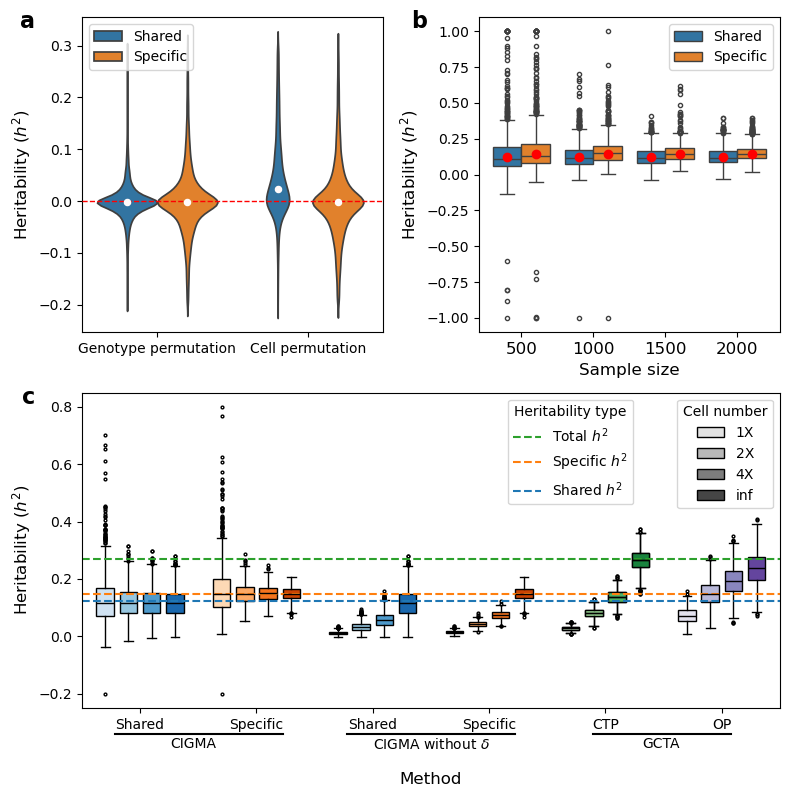

In [8]:
# plot
fs = 12
colors = sns.color_palette()

# Create a gridspec layout
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 2)

# permutation
ax = fig.add_subplot(gs[0, 0])
ct_df_tmp = ct_df.loc[(ct_df['bio_var'] > 0) & (ct_df['var_shared_h2'] < 100) & (ct_df['var_specific_h2'] < 100), ['shared_h2', 'specific_h2', 'perm']]  # NOTE: using var(h2) < 100
geno_df_tmp = geno_df.loc[(geno_df['bio_var'] > 0) & (geno_df['var_shared_h2'] < 100) & (geno_df['var_specific_h2'] < 100), ['shared_h2', 'specific_h2', 'perm']]
print(f'Total gene: {ct_df.shape[0]} and {geno_df.shape[0]}; Remained gene: {ct_df_tmp.shape[0]}, {geno_df_tmp.shape[0]}')
data2 = pd.concat([ct_df_tmp, geno_df_tmp])  
data2 = data2.melt(id_vars=['perm'], var_name='Type', value_name='var')

# data2['var'] = data2['var'].clip(-.25, .3)  # clip
assert ~data2['var'].isna().any()
data2.loc[(data2['var'] < -.2) | (data2['var'] > .3), 'var'] = np.nan  # NOTE
print(f'removed number of values: {data2["var"].isna().sum()}, {data2["var"].isna().sum() / data2.shape[0]}')
sns.violinplot(data2, x='perm', y='var', hue='Type', order=['Genotype permutation', 'Cell permutation'], ax=ax, inner=None, )
# sns.boxplot(data2, x='perm', y='var', hue='Type', order=['Genotype permutation', 'Cell permutation'], ax=ax, showcaps=False, whiskerprops={'linewidth': 0}, showfliers=False)
xs = plot.snsbox_get_x(len(data2['perm'].unique()), 2)
dodge = (xs[1] - xs[0])
sns.pointplot(data2, x='perm', y='var', hue='Type', order=['Genotype permutation', 'Cell permutation'], ax=ax, estimator=np.median, 
              markers='.', linestyles="none", palette=['snow', 'snow'], dodge=dodge, err_kws={'linewidth':1, 'alpha':0.3}, zorder=10, seed=123)
# sns.pointplot(data2, x='perm', y='var', hue='Type', order=['Genotype permutation', 'Cell permutation'], ax=ax, estimator=np.median, 
#               markers='o', linestyles="none", dodge=dodge, errorbar=('pi', 50), err_kws={'linewidth':1, 'alpha':0.3}, capsize=0.02, zorder=10, seed=123)
ax.axhline(0, color='r', linestyle='--', lw=1, zorder=9)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Shared', 'Specific'], fontsize=fs-2, loc='upper left')
# ax.legend().remove()
# ax.set_xlabel('Permutation', fontsize=12)
ax.set_xlabel('', fontsize=12)
ax.set_ylabel(r'Heritability ($h^2$)', fontsize=12)
# ax.set_xticks(ticks=[0, 1], labels=['Cell permutation', 'Genotype permutation'], fontsize=10)
# ax.set_xlim(-.3, 1.3)
fig.text(.05, .99, 'a', fontsize=fs+4, fontweight='bold', va='top', ha='right')

# sample size: unbised estiamtes
ax = fig.add_subplot(gs[0, 1])
ss_data['h2'] = ss_data['h2'].clip(-1, 1)  # NOTE: clip
sns.boxplot(data=ss_data, x='Sample size', y='h2', hue='Category', ax=ax, flierprops=dict(marker='.'))

ax.set_xlabel('Sample size', fontsize=fs)
ax.set_ylabel(r'Heritability ($h^2$)', fontsize=fs)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, fontsize=fs-2)
plt.tick_params(axis='x', labelsize=fs)

xs = plot.snsbox_get_x(len(ss), 2)
ax.scatter(xs, h2, color='r', zorder=10)
fig.text(.54, .99, 'b', fontsize=fs+4, fontweight='bold', va='top', ha='right')


# boxes
ax = fig.add_subplot(gs[1, 0:])
nu_df['h2'] = nu_df['h2'].clip(lower=-0.2, upper=.8)  # NOTE: clip
# sns.boxplot(data=data, x='Category', y='h2', hue='Cell number', ax=ax, palette=palette, flierprops={"marker": "."})
width = 0.15
offset = 0.2
positions = np.array([-1.5, -.5, .5, 1.5 ]) * offset
for i, cat in enumerate(categories):
    if cat in ['GCTA on CTP']:
        palette = [plt.cm.Greens(i) for i in range(50, 256, 50)] 
    elif cat in ['GCTA on OP']:
        palette = [plt.cm.Purples(i) for i in range(50, 256, 50)] 
    elif cat in ['CIGMA (Shared)', 'CIGMA without nu (Shared)']:
        palette = [plt.cm.Blues(i) for i in range(50, 256, 50)] 
    elif cat in ['CIGMA (Specific)', 'CIGMA without nu (Specific)']:
        palette = [plt.cm.Oranges(i) for i in range(50, 256, 50)] 
    for j, cell in enumerate(cell_no):
        if cat != 'GCTA on CTP':
            ax.boxplot(nu_df.loc[(nu_df['Category'] == cat) & (nu_df['Cell number'] == cell), 'h2'], positions=[i + (j - 1.5) * offset], widths=width,
                    patch_artist=True, boxprops=dict(facecolor=palette[j], color='black'), medianprops=dict(color='black'), 
                    flierprops={"marker": ".", "markersize": 4},)
        else:
            tmp_palette = [plt.cm.Grays(i) for i in range(50, 256, 50)] 
            ax.boxplot(nu_df.loc[(nu_df['Category'] == cat) & (nu_df['Cell number'] == cell), 'h2'], positions=[i + (j - 1.5) * offset], widths=width,
                    patch_artist=True, boxprops=dict(facecolor=tmp_palette[j], color='black'), medianprops=dict(color='black'), 
                    flierprops={"marker": ".", "markersize": 4}, label=cell)
            ax.boxplot(nu_df.loc[(nu_df['Category'] == cat) & (nu_df['Cell number'] == cell), 'h2'], positions=[i + (j - 1.5) * offset], widths=width,
                    patch_artist=True, boxprops=dict(facecolor=palette[j], color='black'), medianprops=dict(color='black'), 
                    flierprops={"marker": ".", "markersize": 4})
            
ax.set_xlabel('\n\nMethod', fontsize=fs)
ax.set_ylabel(r'Heritability ($h^2$)', fontsize=fs)
handles, labels = ax.get_legend_handles_labels()
legend1 = ax.legend(handles=handles, labels=labels, fontsize=fs-2, loc='upper right', title='Cell number')
ax.add_artist(legend1)

ax.set_xticks(range(len(categories)))
ax.set_xticklabels(['Shared', 'Specific', 'Shared', 'Specific', 'CTP', 'OP'])
y = 0.085
line = lines.Line2D([0.15, 0.36], [y, y], color='black', transform=fig.transFigure)
fig.lines.append(line)
ax.text(0.16, -0.115, 'CIGMA', transform=ax.transAxes, fontsize=fs-2, ha='center', va='center')
line = lines.Line2D([0.44, 0.65], [y, y], color='black', transform=fig.transFigure)
fig.lines.append(line)
ax.text(0.5, -0.115, 'CIGMA without $\\delta$', transform=ax.transAxes, fontsize=fs-2, ha='center', va='center')
line = lines.Line2D([0.747, 0.92], [y, y], color='black', transform=fig.transFigure)
fig.lines.append(line)
ax.text(0.83, -0.115, 'GCTA', transform=ax.transAxes, fontsize=fs-2, ha='center', va='center')

line1 = ax.axhline(nu_total_h2[0], ls='--', color=colors[2], label='Total $h^2$')
line2 = ax.axhline(nu_specific_h2[0], ls='--', color=colors[1], label='Specific $h^2$')
line3 = ax.axhline(nu_shared_h2[0], ls='--', color=colors[0], label='Shared $h^2$')
# line4 = ax.axhline(nu_additive_h2[3], ls='--', color=colors[4], label='Additive $h^2$')
legend2 = ax.legend(handles=[line1, line2, line3], loc='upper right', bbox_to_anchor=(0.80, 1), title='Heritability type')

fig.text(0.05, .52, 'c', fontsize=fs+4, fontweight='bold', va='top', ha='right')
ax.set_xlim(-.5, 5.5)

fig.tight_layout()

# REML

In [9]:
chol = np.load('../../analysis/sim/free/ss~1000_a~2_2_2_2_vc~0.1_0.05_0.15_0.02_0.05_0.63_beta~8_4_2_1_V_diag~1_1_1_1_V_tril~0_W_diag~1_1_1_1_W_tril~0_std_nu_scale~0.4/out.reml.npy', allow_pickle=True).item()
nochol = np.load('../../analysis/sim/free/ss~1000_a~2_2_2_2_vc~0.1_0.05_0.15_0.02_0.05_0.63_beta~8_4_2_1_V_diag~1_1_1_1_V_tril~0_W_diag~1_1_1_1_W_tril~0_std_nu_scale~0.4/out.reml.noCholesky.npy', allow_pickle=True).item()

In [17]:
print(chol['free']['opt'].keys())
print(chol['free']['opt']['time'].shape)
print(nochol['free']['opt']['time'].shape)
print(np.unique(chol['free']['opt']['success']))
print(np.unique(nochol['free']['opt']['success']))

dict_keys(['success', 'status', 'message', 'l', 'initial', 'niter', 'time'])
(1000,)
(1000,)
[ True]
[ True]


In [15]:
print(np.mean(chol['free']['opt']['time']))
print(np.mean(nochol['free']['opt']['time']))

1376.5109771077632
23753.662935248376
